IMPORT NECESSARY LIBRARY

In [41]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer

1. DATA PREPARATION

1.1. LOADING DATA


In [42]:
data = pd.read_csv('./train.csv', sep=';')
customers = data.copy()
customers.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


1.2. SELECTING AND TRANSFORM FEATURE

In [43]:
#Rename column 'y' to 'term_deposit' and 'default' to 'credit'
customers = data.rename(columns={'y':'term_deposit', 'default':'credit'})
customers.head()

,age,job,marital,education,credit,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [44]:
#Merge column 'day' and 'month' to 'recency'
def toRecency(data, upper_):
    enc = [upper_]
    enc[0] = 1
    for x in range(1, upper_):
        if data[x] == data[x-1]:
            enc.append(enc[x-1])
        else:
            enc.append(enc[x-1]+1)
    for x in range(0, upper_):
        enc[x] = enc[upper_ - 1] - enc[x] + 1
    return enc

customers['month'] = pd.to_datetime(customers['month'], format='%b').dt.month
customers['day'] = customers['month'].astype(str) + customers['day'].astype(str)
customers.drop('month', axis=1, inplace=True)
customers['day'] = customers['day'].astype(np.int64)
toRecent = toRecency(customers['day'], len(customers['day']))
customers['recency'] = toRecent
customers.drop('day', axis=1, inplace=True)

In [45]:
#Encode binary feature 
enc_bin = {'yes':1, 'no':0}
customers['credit'] = customers['credit'].map(enc_bin)
customers['housing'] = customers['housing'].map(enc_bin)
customers['loan'] = customers['loan'].map(enc_bin)
customers['term_deposit'] = customers['term_deposit'].map(enc_bin)

In [46]:
#Create current frequency columns
customers['AverDuration'] = customers['duration']/customers['campaign']
Y = list(customers['AverDuration'])
for i in range(len(Y)):
    if Y[i]>=360: Y[i]=360
customers['AverDuration'] = Y
customers['frequency'] = 1/(customers['AverDuration']+1)
customers.drop(['campaign','duration', 'AverDuration'], axis=1, inplace=True)

In [47]:
#Rename 'balance' to 'monetary'
customers = customers.rename(columns={"balance":"monetary"})

In [48]:
#Create 'service' from 'loan', 'housing', 'credit', 'term_deposit'
customers['service'] =(customers['loan'] + customers['housing'] + customers['term_deposit'] + customers['credit'])/4
customers.drop(['housing', 'loan', 'term_deposit', 'credit'], axis=1, inplace=True)

In [49]:
customers_ = customers.copy()
customers.head()

,age,job,marital,education,monetary,contact,pdays,previous,poutcome,recency,frequency,service
0,58,management,married,tertiary,2143,unknown,-1,0,unknown,561,0.003817,0.25
1,44,technician,single,secondary,29,unknown,-1,0,unknown,561,0.006579,0.25
2,33,entrepreneur,married,secondary,2,unknown,-1,0,unknown,561,0.012987,0.50
3,47,blue-collar,married,unknown,1506,unknown,-1,0,unknown,561,0.010753,0.25
4,33,unknown,single,unknown,1,unknown,-1,0,unknown,561,0.005025,0.00


In [50]:
def shrinkLog(data):
    X = list(data)
    for i in range(len(X)):
        if X[i] < -1 : X[i] = -np.log(-X[i]) - 1
        elif X[i] > 1 : X[i] = np.log(X[i]) + 1
        else: X[i] = X[i]
    return X

customers_['monetary'] = shrinkLog(customers_['monetary'])
customers_['recency'] = shrinkLog(customers_['recency'])

In [51]:
customers_.head()

,age,job,marital,education,monetary,contact,pdays,previous,poutcome,recency,frequency,service
0,58,management,married,tertiary,8.669962,unknown,-1,0,unknown,7.329721,0.003817,0.25
1,44,technician,single,secondary,4.367296,unknown,-1,0,unknown,7.329721,0.006579,0.25
2,33,entrepreneur,married,secondary,1.693147,unknown,-1,0,unknown,7.329721,0.012987,0.50
3,47,blue-collar,married,unknown,8.317212,unknown,-1,0,unknown,7.329721,0.010753,0.25
4,33,unknown,single,unknown,1.000000,unknown,-1,0,unknown,7.329721,0.005025,0.00


In [52]:
#One-hot encoding for categorical feature
customer_get_dummies = pd.get_dummies(customers_[['job','marital','education','contact', 'poutcome']])
customers_ = customers_.join(customer_get_dummies)
customers_.drop(['job','marital','education','contact', 'poutcome'], axis=1, inplace=True)

1.3. RESCALING FEATURE

In [53]:
scaler = MinMaxScaler()
customers_ = scaler.fit_transform(customers_)
customers_ = pd.DataFrame(customers_)

In [54]:
customers_.head(10)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.519481,0.828446,0.0,0.0,1.0,0.001050,0.25,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.337662,0.637416,0.0,0.0,1.0,0.003819,0.25,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.194805,0.518689,0.0,0.0,1.0,0.010245,0.50,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.376623,0.812784,0.0,0.0,1.0,0.008005,0.25,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.194805,0.487915,0.0,0.0,1.0,0.002261,0.00,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.220779,0.729547,0.0,0.0,1.0,0.004385,0.25,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.129870,0.758856,0.0,0.0,1.0,0.001822,0.50,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,0.311688,0.518689,0.0,0.0,1.0,0.000000,0.50,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,0.519481,0.700838,0.0,0.0,1.0,0.016885,0.25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,0.324675,0.771405,0.0,0.0,1.0,0.015129,0.25,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


2. IMPLEMENT KMEANS

2.1. ESTIMATING NUMBER OF CLUSTER

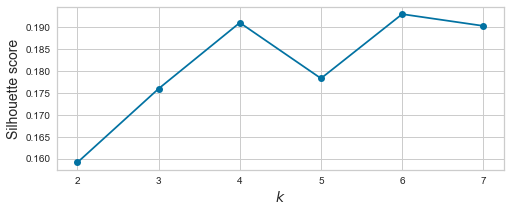

In [55]:
def lineSilhouetteScore(data, lower_, upper_):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data) for k in range(lower_, upper_)]
    silhouette_scores = [silhouette_score(data, model.labels_) for model in kmeans_per_k]
    plt.figure(figsize=(8, 3))
    plt.plot(range(lower_, upper_), silhouette_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)
    plt.show()

lineSilhouetteScore(customers_, 2, 8)

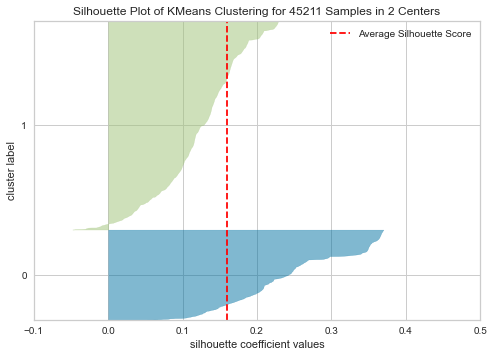

For n_clusters = 2, Kmeans silhouette score is 0.15911481999099347


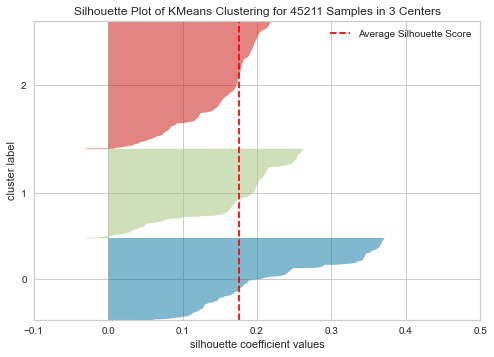

For n_clusters = 3, Kmeans silhouette score is 0.17598508509894045


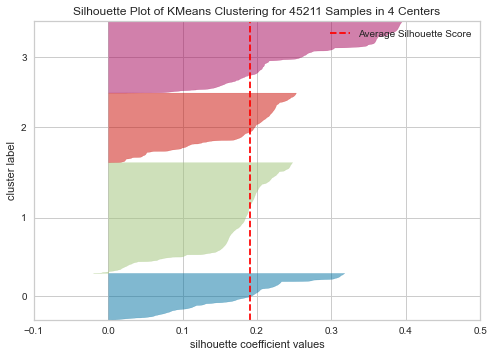

For n_clusters = 4, Kmeans silhouette score is 0.19107596289561796


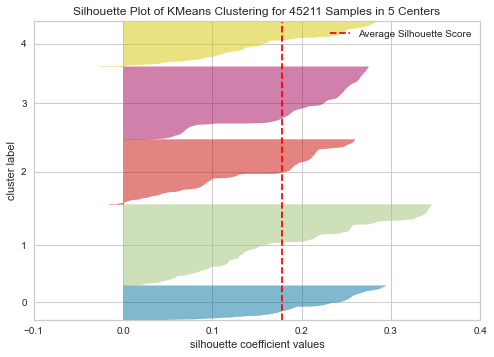

For n_clusters = 5, Kmeans silhouette score is 0.17832755476752923


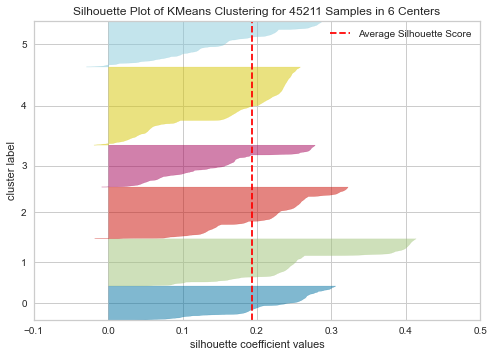

For n_clusters = 6, Kmeans silhouette score is 0.19303668920525346


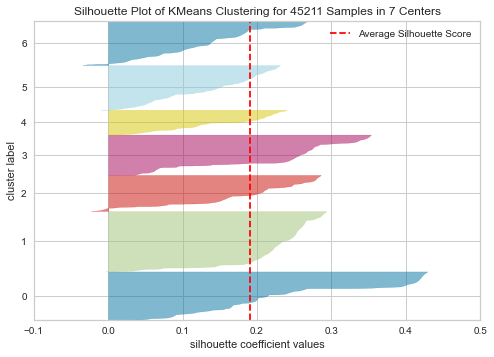

For n_clusters = 7, Kmeans silhouette score is 0.19034781910147427


In [56]:
def showSilhouetteScore(data, lower_, upper_):
    for n_clusters in range(lower_, upper_):
        model = KMeans(n_clusters, random_state=42)
        visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
        visualizer.fit(data)
        visualizer.show()
        print("For n_clusters = {}, Kmeans silhouette score is {}".format(n_clusters, visualizer.silhouette_score_))

showSilhouetteScore(customers_, 2, 8)

{2: 113771.83586636036,
 3: 99702.40643904466,
 4: 91966.53015660784,
 5: 85521.94286634267,
 6: 79965.58984781752,
 7: 76539.65623062616}

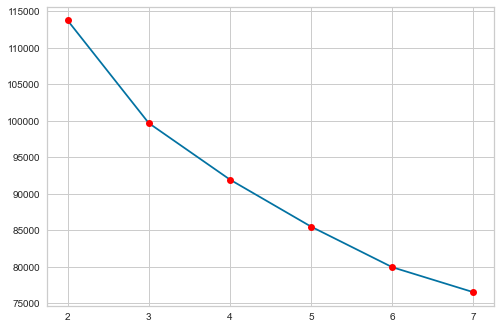

In [57]:
def showElbow(data, lower_, upper_):
    sse = {}
    for k in range(lower_,upper_):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    sse_keys = list(sse.keys())
    sse_values = list(sse.values())
    plt.plot(sse_keys, sse_values, marker='o', markerfacecolor='red')
    return sse

showElbow(customers_, 2, 8)

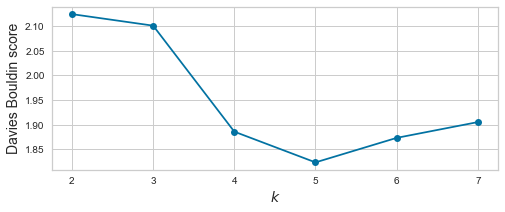

In [58]:
def showDaviesBouldinScore(data, lower_, upper_):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data) for k in range(lower_, upper_)]
    CH_scores = [davies_bouldin_score(data, model.labels_) for model in kmeans_per_k]
    plt.figure(figsize=(8, 3))
    plt.plot(range(lower_, upper_), CH_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Davies Bouldin score", fontsize=14)
    plt.show()

showDaviesBouldinScore(customers_, 2, 8)

2.2. CREATING K-MEANS MODEL AND TRAINING 

In [59]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred_kmeans = kmeans.fit_predict(customers_)

from sklearn.metrics import silhouette_score
s = silhouette_score(customers_, y_pred_kmeans)
customers['labels'] = y_pred_kmeans

In [60]:
s

0.19303668920525346

In [61]:
customers_0 = customers[customers['labels']==0]
customers_0.describe(include='all')

,age,job,marital,education,monetary,contact,pdays,previous,poutcome,recency,frequency,service,labels
count,5179.000000,5179,5179,5179,5179.000000,5179,5179.000000,5179.000000,5179,5179.000000,5179.000000,5179.000000,5179.0
unique,NaN,12,1,3,NaN,2,NaN,NaN,4,NaN,NaN,NaN,NaN
top,NaN,technician,single,secondary,NaN,cellular,NaN,NaN,unknown,NaN,NaN,NaN,NaN
freq,NaN,1296,5179,4681,NaN,4819,NaN,NaN,3758,NaN,NaN,NaN,NaN
mean,33.038811,NaN,NaN,NaN,1136.448928,NaN,64.815601,0.854991,NaN,394.688164,0.027272,0.206748,0.0
std,7.730133,NaN,NaN,NaN,2273.388399,NaN,122.403340,2.213328,NaN,106.688266,0.068681,0.169455,0.0
min,18.000000,NaN,NaN,NaN,-8019.000000,NaN,-1.000000,0.000000,NaN,1.000000,0.002770,0.000000,0.0
25%,28.000000,NaN,NaN,NaN,83.500000,NaN,-1.000000,0.000000,NaN,368.000000,0.004287,0.000000,0.0
50%,32.000000,NaN,NaN,NaN,387.000000,NaN,-1.000000,0.000000,NaN,393.000000,0.008547,0.250000,0.0
75%,36.500000,NaN,NaN,NaN,1186.000000,NaN,91.000000,1.000000,NaN,477.500000,0.018692,0.250000,0.0


In [62]:
customers_1 = customers[customers['labels']==1]
customers_1.describe(include='all')

,age,job,marital,education,monetary,contact,pdays,previous,poutcome,recency,frequency,service,labels
count,7131.000000,7131,7131,7131,7131.000000,7131,7131.000000,7131.000000,7131,7131.000000,7131.000000,7131.000000,7131.0
unique,NaN,12,1,2,NaN,3,NaN,NaN,4,NaN,NaN,NaN,NaN
top,NaN,management,married,tertiary,NaN,cellular,NaN,NaN,unknown,NaN,NaN,NaN,NaN
freq,NaN,4410,7131,7021,NaN,5407,NaN,NaN,5755,NaN,NaN,NaN,NaN
mean,42.415930,NaN,NaN,NaN,1846.267985,NaN,36.681812,0.649698,NaN,436.700743,0.028512,0.191418,1.0
std,9.944984,NaN,NaN,NaN,3918.389869,NaN,91.925518,3.754884,NaN,112.763440,0.066955,0.174341,0.0
min,23.000000,NaN,NaN,NaN,-6847.000000,NaN,-1.000000,0.000000,NaN,1.000000,0.002770,0.000000,1.0
25%,34.000000,NaN,NaN,NaN,102.000000,NaN,-1.000000,0.000000,NaN,378.000000,0.005376,0.000000,1.0
50%,40.000000,NaN,NaN,NaN,601.000000,NaN,-1.000000,0.000000,NaN,482.000000,0.010929,0.250000,1.0
75%,50.000000,NaN,NaN,NaN,1907.500000,NaN,-1.000000,0.000000,NaN,509.000000,0.023810,0.250000,1.0


In [63]:
customers_2 = customers[customers['labels']==2]
customers_2.describe(include="all")

,age,job,marital,education,monetary,contact,pdays,previous,poutcome,recency,frequency,service,labels
count,7838.000000,7838,7838,7838,7838.000000,7838,7838.000000,7838.000000,7838,7838.000000,7838.000000,7838.000000,7838.0
unique,NaN,12,3,3,NaN,2,NaN,NaN,4,NaN,NaN,NaN,NaN
top,NaN,blue-collar,married,secondary,NaN,unknown,NaN,NaN,unknown,NaN,NaN,NaN,NaN
freq,NaN,2344,4740,7158,NaN,7826,NaN,NaN,7794,NaN,NaN,NaN,NaN
mean,39.776601,NaN,NaN,NaN,1064.684103,NaN,1.142511,0.026793,NaN,536.083822,0.027967,0.243621,2.0
std,9.391420,NaN,NaN,NaN,2459.000588,NaN,33.993491,0.614401,NaN,64.636339,0.065543,0.158318,0.0
min,20.000000,NaN,NaN,NaN,-2093.000000,NaN,-1.000000,0.000000,NaN,16.000000,0.002770,0.000000,2.0
25%,32.000000,NaN,NaN,NaN,39.000000,NaN,-1.000000,0.000000,NaN,538.000000,0.004966,0.250000,2.0
50%,38.000000,NaN,NaN,NaN,352.000000,NaN,-1.000000,0.000000,NaN,546.000000,0.009901,0.250000,2.0
75%,47.000000,NaN,NaN,NaN,1117.000000,NaN,-1.000000,0.000000,NaN,554.000000,0.021898,0.250000,2.0


In [64]:
customers_3 = customers[customers['labels']==3]
customers_3.describe(include='all')

,age,job,marital,education,monetary,contact,pdays,previous,poutcome,recency,frequency,service,labels
count,6342.000000,6342,6342,6342,6342.000000,6342,6342.000000,6342.000000,6342,6342.000000,6342.000000,6342.000000,6342.0
unique,NaN,12,2,3,NaN,3,NaN,NaN,4,NaN,NaN,NaN,NaN
top,NaN,management,single,tertiary,NaN,cellular,NaN,NaN,unknown,NaN,NaN,NaN,NaN
freq,NaN,3581,4852,6262,NaN,4783,NaN,NaN,5004,NaN,NaN,NaN,NaN
mean,36.597130,NaN,NaN,NaN,1652.239357,NaN,42.273258,0.692684,NaN,425.666667,0.028788,0.198084,3.0
std,8.966721,NaN,NaN,NaN,3705.555390,NaN,100.191373,2.261630,NaN,118.930988,0.070502,0.168761,0.0
min,20.000000,NaN,NaN,NaN,-4057.000000,NaN,-1.000000,0.000000,NaN,1.000000,0.002770,0.000000,3.0
25%,30.000000,NaN,NaN,NaN,112.000000,NaN,-1.000000,0.000000,NaN,372.000000,0.004681,0.000000,3.0
50%,34.000000,NaN,NaN,NaN,559.000000,NaN,-1.000000,0.000000,NaN,453.000000,0.009709,0.250000,3.0
75%,41.000000,NaN,NaN,NaN,1695.250000,NaN,-1.000000,0.000000,NaN,508.000000,0.021612,0.250000,3.0


In [65]:
customers_4 = customers[customers['labels']==4]
customers_4.describe(include='all')

,age,job,marital,education,monetary,contact,pdays,previous,poutcome,recency,frequency,service,labels
count,11819.000000,11819,11819,11819,11819.000000,11819,11819.000000,11819.000000,11819,11819.000000,11819.000000,11819.000000,11819.0
unique,NaN,12,2,2,NaN,2,NaN,NaN,4,NaN,NaN,NaN,NaN
top,NaN,technician,married,secondary,NaN,cellular,NaN,NaN,unknown,NaN,NaN,NaN,NaN
freq,NaN,2759,9877,11363,NaN,10777,NaN,NaN,8736,NaN,NaN,NaN,NaN
mean,43.421863,NaN,NaN,NaN,1272.495643,NaN,59.456130,0.792453,NaN,419.724427,0.028871,0.220704,4.0
std,10.225651,NaN,NaN,NaN,2844.489305,NaN,115.910458,2.088981,NaN,97.650397,0.070480,0.175270,0.0
min,20.000000,NaN,NaN,NaN,-2082.000000,NaN,-1.000000,0.000000,NaN,1.000000,0.002770,0.000000,4.0
25%,35.000000,NaN,NaN,NaN,61.000000,NaN,-1.000000,0.000000,NaN,373.000000,0.004955,0.000000,4.0
50%,42.000000,NaN,NaN,NaN,442.000000,NaN,-1.000000,0.000000,NaN,439.000000,0.010101,0.250000,4.0
75%,51.000000,NaN,NaN,NaN,1362.000000,NaN,81.000000,1.000000,NaN,497.000000,0.022059,0.250000,4.0


In [66]:
customers_5 = customers[customers['labels']==5]
customers_5.describe(include='all')

,age,job,marital,education,monetary,contact,pdays,previous,poutcome,recency,frequency,service,labels
count,6902.000000,6902,6902,6902,6902.000000,6902,6902.000000,6902.000000,6902,6902.000000,6902.000000,6902.000000,6902.0
unique,NaN,12,3,2,NaN,3,NaN,NaN,4,NaN,NaN,NaN,NaN
top,NaN,blue-collar,married,primary,NaN,cellular,NaN,NaN,unknown,NaN,NaN,NaN,NaN
freq,NaN,3901,5466,6660,NaN,3499,NaN,NaN,5912,NaN,NaN,NaN,NaN
mean,46.380759,NaN,NaN,NaN,1256.904376,NaN,34.824978,0.464648,NaN,462.079977,0.030284,0.204216,5.0
std,11.421496,NaN,NaN,NaN,2677.632720,NaN,96.418651,1.844910,NaN,102.671813,0.072114,0.164132,0.0
min,18.000000,NaN,NaN,NaN,-2604.000000,NaN,-1.000000,0.000000,NaN,1.000000,0.002770,0.000000,5.0
25%,38.000000,NaN,NaN,NaN,61.000000,NaN,-1.000000,0.000000,NaN,387.000000,0.005155,0.000000,5.0
50%,46.000000,NaN,NaN,NaN,410.000000,NaN,-1.000000,0.000000,NaN,501.000000,0.010471,0.250000,5.0
75%,54.000000,NaN,NaN,NaN,1410.500000,NaN,-1.000000,0.000000,NaN,538.000000,0.024086,0.250000,5.0
